# Pylops - Marchenko on GPU with cupy

In [39]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
import numpy as np
import cupy as cp
import scipy as sp
import cusignal
import matplotlib.pyplot as plt

from scipy.signal import convolve, filtfilt
from scipy.sparse.linalg import inv, lsqr
from scipy.sparse import rand

from pylops.utils import dottest
from pylops.utils.wavelets import *
from pylops.utils.tapers import *
from pylops import LinearOperator
from pylops.basicoperators import *
from pylops.signalprocessing import *
from pylops.waveeqprocessing.mdd import MDC
from pylops.waveeqprocessing.marchenko import directwave, Marchenko
from pylops.optimization.basic import cgls

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [40]:
vel = 2400.0        # velocity
toff = 0.045        # direct arrival time shift
nsmooth = 10        # time window smoothing 
nfmax = 500         # max frequency for MDC (#samples)
nstaper = 11        # source/receiver taper lenght
n_iter = 10         # iterations

jr = 1              # subsampling in r
js = 1              # subsampling in s

inputfile = '../data/marchenko/input.npz'
inputdata = np.load(inputfile)

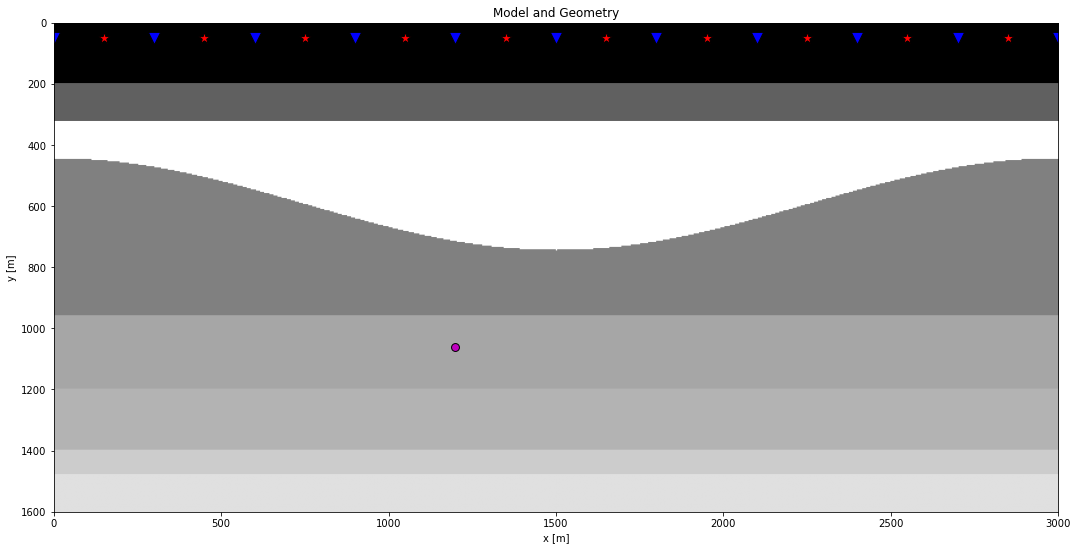

In [41]:
# Receivers
r = inputdata['r'][:,::jr]
nr = r.shape[1]
dr = r[0,1]-r[0,0]

# Sources
s = inputdata['s'][:,::js]
ns = s.shape[1]
ds = s[0,1]-s[0,0]

# Virtual points
vs = inputdata['vs']

# Density model
rho = inputdata['rho']
z, x = inputdata['z'], inputdata['x']

plt.figure(figsize=(18,9))
plt.imshow(rho, cmap='gray', extent = (x[0], x[-1], z[-1], z[0]))
plt.scatter(s[0, 5::10], s[1, 5::10], marker='*', s=150, c='r', edgecolors='k')
plt.scatter(r[0, ::10],  r[1, ::10], marker='v', s=150, c='b', edgecolors='k')
plt.scatter(vs[0], vs[1], marker='.', s=250, c='m', edgecolors='k')
plt.axis('tight')
plt.xlabel('x [m]'),plt.ylabel('y [m]'),plt.title('Model and Geometry')
plt.xlim(x[0], x[-1]);

In [42]:
# time axis
t = inputdata['t']
ot, dt, nt = t[0], t[1]-t[0], len(t)

# data
R = inputdata['R'][::js, ::jr]
R = np.swapaxes(R, 0, 1) # R[r, s, f] (for data with dipole source, you need to integrate over sources)

# tapering
taper = taper3d(nt, [ns, nr], [nstaper, nstaper], tapertype='hanning')
R = R*taper

In [43]:
Gsub = inputdata['Gsub'][:, ::jr]
G0sub = inputdata['G0sub'][:, ::jr]
wav = inputdata['wav']
wav_c = np.argmax(wav)

# convolve with wavelet
Gsub = np.apply_along_axis(convolve, 0, Gsub, wav, mode='full')
Gsub = Gsub[wav_c:][:nt]
G0sub = np.apply_along_axis(convolve, 0, G0sub, wav, mode='full') 
G0sub = G0sub[wav_c:][:nt]

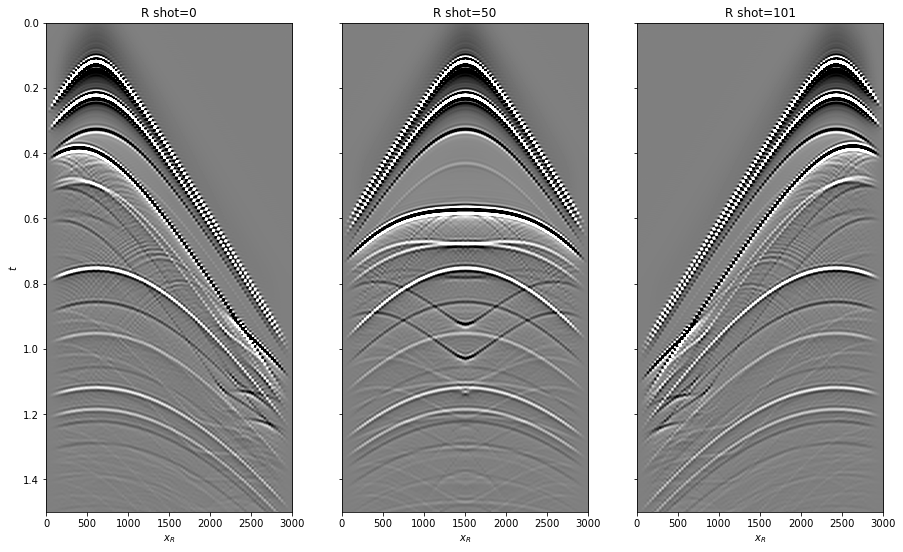

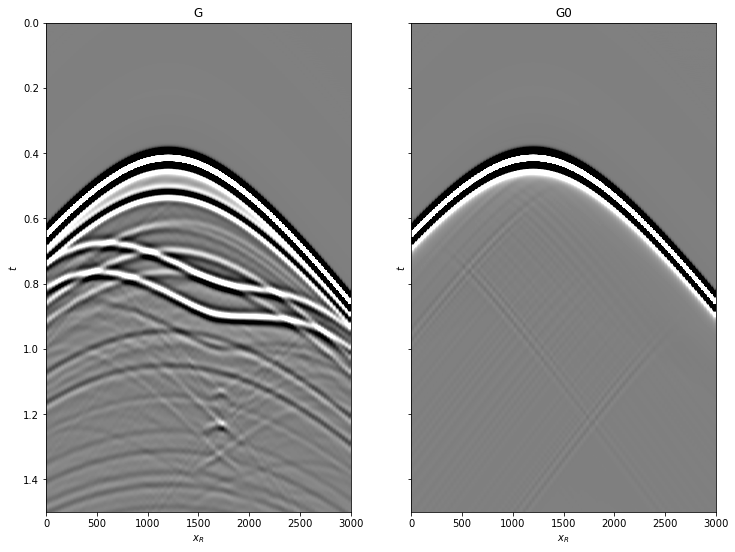

In [44]:
fig, axs = plt.subplots(1, 3, sharey=True, figsize=(15, 9))
axs[0].imshow(R[20].T, cmap='gray', vmin=-1e-2, vmax=1e-2, extent=(r[0,0], r[0,-1], t[-1], t[0]))
axs[0].set_title('R shot=0'), axs[0].set_xlabel(r'$x_R$'), axs[0].set_ylabel(r'$t$')
axs[0].axis('tight')
axs[0].set_ylim(1.5, 0)
axs[1].imshow(R[ns//2].T, cmap='gray', vmin=-1e-2, vmax=1e-2, extent=(r[0,0], r[0,-1], t[-1], t[0]))
axs[1].set_title('R shot=%d' %(ns//2)), axs[1].set_xlabel(r'$x_R$')
axs[1].axis('tight')
axs[1].set_ylim(1.5, 0)
axs[2].imshow(R[-20].T, cmap='gray', vmin=-1e-2, vmax=1e-2, extent=(r[0,0], r[0,-1], t[-1], t[0]))
axs[2].set_title('R shot=%d' %ns), axs[2].set_xlabel(r'$x_R$')
axs[2].axis('tight');
axs[2].set_ylim(1.5, 0)

fig, axs = plt.subplots(1, 2, sharey=True, figsize=(12, 9))
axs[0].imshow(Gsub, cmap='gray', vmin=-1e5, vmax=1e5, extent=(r[0,0], r[0,-1], t[-1], t[0]))
axs[0].set_title('G'), axs[0].set_xlabel(r'$x_R$'), axs[0].set_ylabel(r'$t$')
axs[0].axis('tight')
axs[0].set_ylim(1.5, 0)
axs[1].imshow(G0sub, cmap='gray', vmin=-1e5, vmax=1e5, extent=(r[0,0], r[0,-1], t[-1], t[0]))
axs[1].set_title('G0'), axs[1].set_xlabel(r'$x_R$'), axs[1].set_ylabel(r'$t$')
axs[1].axis('tight')
axs[1].set_ylim(1.5, 0);

/tmp/ipykernel_22783/856555058.py:6: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  idirectVS_off = np.round(directVS_off/dt).astype(np.int)


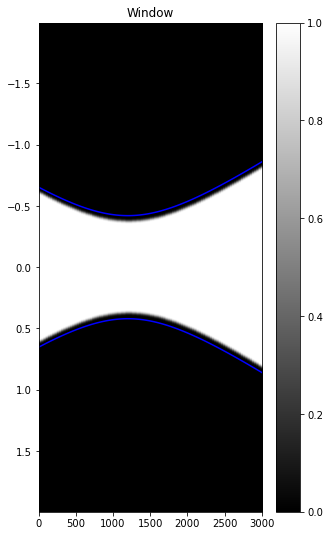

In [45]:
# direct arrival window - traveltime
directVS = np.sqrt((vs[0]-r[0])**2+(vs[1]-r[1])**2)/vel
directVS_off = directVS - toff

# window
idirectVS_off = np.round(directVS_off/dt).astype(np.int)
w = np.zeros((nr, nt))
for ir in range(nr):
    w[ir, :idirectVS_off[ir]]=1            
w = np.hstack((np.fliplr(w), w[:, 1:]))

if nsmooth>0:
    smooth=np.ones(nsmooth)/nsmooth
    w  = filtfilt(smooth, 1, w)    
    
fig, ax = plt.subplots(1, 1,  sharey=True, figsize=(5, 9))
im = ax.imshow(w.T, cmap='gray', extent=(r[0,0], r[0,-1], t[-1], -t[-1]))
ax.plot(r[0], directVS,'b'),ax.plot(r[0], -directVS,'b')
ax.set_title('Window'), axs[0].set_xlabel(r'$x_R$'), axs[0].set_ylabel(r'$t$')
ax.axis('tight')
fig.colorbar(im, ax=ax);

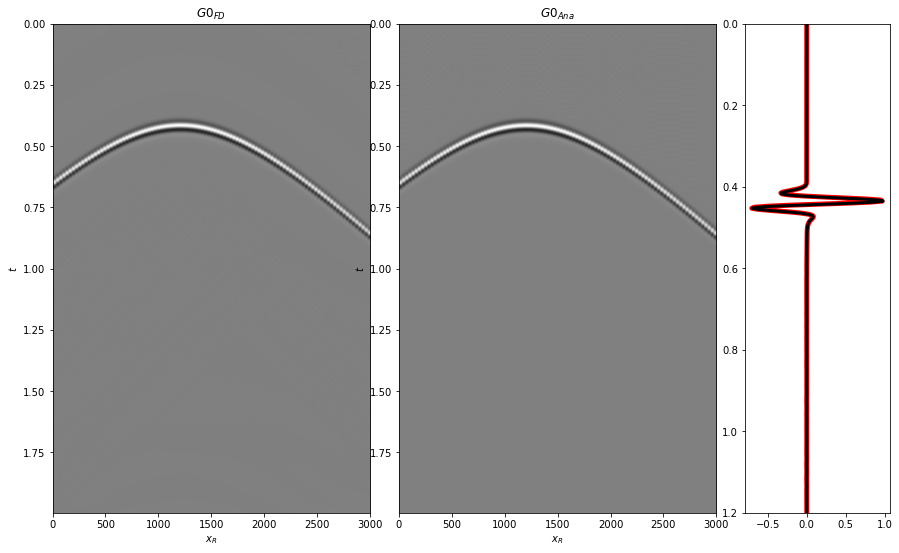

In [46]:
G0sub_ana = directwave(wav, directVS, nt, dt, nfft=2**11)

fig = plt.figure(figsize=(15,9))
ax1 = plt.subplot2grid((1, 5), (0, 0), colspan=2)
ax2 = plt.subplot2grid((1, 5), (0, 2), colspan=2)
ax3 = plt.subplot2grid((1, 5), (0, 4))

ax1.imshow(G0sub/G0sub.max(), cmap='gray', vmin=-1, vmax=1, 
           extent=(r[0,0], r[0,-1], t[-1], t[0]))
ax1.set_title(r'$G0_{FD}$'), ax1.set_xlabel(r'$x_R$'), ax1.set_ylabel(r'$t$')
ax1.axis('tight')
ax2.imshow(G0sub_ana/G0sub_ana.max(), cmap='gray', vmin=-1, vmax=1, 
           extent=(r[0,0], r[0,-1], t[-1], t[0]))
ax2.set_title(r'$G0_{Ana}$'), ax2.set_xlabel(r'$x_R$'), ax2.set_ylabel(r'$t$')
ax2.axis('tight')

ax3.plot(G0sub[:, nr//2]/G0sub.max(), t, 'r', lw=5)
ax3.plot(G0sub_ana[:, nr//2]/G0sub_ana.max(), t, 'k', lw=3)
ax3.set_ylim(1.2, 0);

## Numpy

In [47]:
# Add negative time to operators
Rtwosided = np.concatenate((np.zeros((nr, ns, nt-1)), R), axis=-1)
Rtwosided_fft = np.fft.rfft(Rtwosided, 2*nt-1, axis=-1)/np.sqrt(2*nt-1)
Rtwosided_fft = Rtwosided_fft[...,:nfmax]
Rtwosided_fft = Rtwosided_fft.transpose(2, 0, 1) # R[f, r, s]

# Operators
Rop = MDC(Rtwosided_fft, nt=2*nt-1, nv=1, dt=dt, dr=ds, twosided=True)
R1op = MDC(Rtwosided_fft, nt=2*nt-1, nv=1, dt=dt, dr=ds, twosided=True, conj=True)
Rollop = Roll(dims=(2*nt-1, nr),
              axis=0, shift=-1)

# Input focusing function
fd_plus =  np.concatenate((np.fliplr(G0sub.T).T, np.zeros((nt-1, nr), dtype='float32')))

Wop = Diagonal(w.T.flatten(), dtype='float32')
Iop = Identity(nr*(2*nt-1), dtype='float32')

Mop = VStack([HStack([Iop, -1*Wop*Rop]),
              HStack([-1*Wop*Rollop*R1op, Iop])])*BlockDiag([Wop, Wop])
Gop = VStack([HStack([Iop, -1*Rop]),
              HStack([-1*Rollop*R1op, Iop])])

p0_minus = Rop * fd_plus.flatten()
p0_minus = p0_minus.reshape((2*nt-1), nr).T

d = Wop*Rop*fd_plus.flatten()
d = np.concatenate((d.reshape(2*nt-1, nr), np.zeros((2*nt-1, nr), dtype='float32')))

f1_adj = Mop.H*d.flatten()
f1_inv = cgls(Mop, d.flatten(), x0=np.zeros(2*(2*nt-1)*nr, dtype='float32'), niter=n_iter, show=True)[0]

f1_adj = f1_adj.reshape(2*(2*nt-1), nr)
f1_inv = f1_inv.reshape(2*(2*nt-1), nr)

CGLS
-----------------------------------------------------------------
The Operator Op has 322998 rows and 322998 cols
damp = 0.000000e+00	tol = 1.000000e-04	niter = 10
-----------------------------------------------------------------

    Itn          x[0]              r1norm         r2norm
     1        0.0000e+00         1.3112e+07     1.3112e+07
     2        0.0000e+00         7.4059e+06     7.4059e+06
     3        0.0000e+00         5.4789e+06     5.4789e+06
     4        0.0000e+00         3.6588e+06     3.6588e+06
     5        0.0000e+00         2.7797e+06     2.7797e+06
     6        0.0000e+00         2.2437e+06     2.2437e+06
     7        0.0000e+00         1.4979e+06     1.4979e+06
     8        0.0000e+00         1.1047e+06     1.1047e+06
     9        0.0000e+00         8.9883e+05     8.9883e+05
    10        0.0000e+00         6.7141e+05     6.7141e+05

Iterations = 10        Total time (s) = 1.69
-----------------------------------------------------------------



## Cupy

In [48]:
# Convert to cupy
G0sub = cp.array(G0sub.astype(np.float32))
G0sub_ana = cp.array(G0sub_ana.astype(np.float32))
R = cp.array(R.astype(np.float32))
w = cp.array(w.astype(np.float32))

In [49]:
# Add negative time to operators
Rtwosided = cp.concatenate((cp.zeros((nr, ns, nt-1)), R), axis=-1)
Rtwosided_fft = np.fft.rfft(Rtwosided, 2*nt-1, axis=-1)/np.sqrt(2*nt-1)
Rtwosided_fft = Rtwosided_fft[...,:nfmax]
Rtwosided_fft = Rtwosided_fft.transpose(2, 0, 1) # R[f, r, s]

# Operators
Rop = MDC(Rtwosided_fft, nt=2*nt-1, nv=1, dt=dt, dr=ds, twosided=True)
R1op = MDC(Rtwosided_fft, nt=2*nt-1, nv=1, dt=dt, dr=ds, twosided=True, conj=True)
Rollop = Roll(dims=(2*nt-1, nr),
              axis=0, shift=-1)

# Input focusing function
fd_plus =  cp.concatenate((cp.fliplr(G0sub.T).T, cp.zeros((nt-1, nr), dtype='float32')))
fd_plus.dtype

dtype('float32')

In [50]:
Wop = Diagonal(w.T.flatten(), dtype='float32')
Iop = Identity(nr*(2*nt-1), dtype='float32')

Mop = VStack([HStack([Iop, -1*Wop*Rop], dtype='float32'),
              HStack([-1*Wop*Rollop*R1op, Iop], dtype='float32')])*BlockDiag([Wop, Wop])
Gop = VStack([HStack([Iop, -1*Rop], dtype='float32'),
              HStack([-1*Rollop*R1op, Iop], dtype='float32')])

dottest(Gop, 2*nr*(2*nt-1), 2*nr*(2*nt-1), verb=True, atol=1e-3, backend='cupy')
dottest(Mop, 2*nr*(2*nt-1), 2*nr*(2*nt-1), verb=True, atol=1e-3, backend='cupy');

Dot test passed, v^H(Opu)=-35.560455322265625 - u^H(Op^Hv)=-35.559783935546875
Dot test passed, v^H(Opu)=329.69317626953125 - u^H(Op^Hv)=329.6932067871094


In [51]:
p0_minus = Rop * fd_plus.flatten()
p0_minus = p0_minus.reshape((2*nt-1), nr).T

In [52]:
d = Wop*Rop*fd_plus.flatten()
d = cp.concatenate((d.reshape(2*nt-1, nr), cp.zeros((2*nt-1, nr), dtype='float32')))

f1_adj = Mop.H*d.flatten()
f1_inv = cgls(Mop, d.flatten(), x0=cp.zeros(2*(2*nt-1)*nr, dtype='float32'), niter=n_iter, show=True)[0]

f1_adj = f1_adj.reshape(2*(2*nt-1), nr)
f1_inv = f1_inv.reshape(2*(2*nt-1), nr)

CGLS
-----------------------------------------------------------------
The Operator Op has 322998 rows and 322998 cols
damp = 0.000000e+00	tol = 1.000000e-04	niter = 10
-----------------------------------------------------------------

    Itn          x[0]              r1norm         r2norm
     1        0.0000e+00         1.3112e+07     1.3112e+07
     2        0.0000e+00         7.4059e+06     7.4059e+06
     3        0.0000e+00         5.4789e+06     5.4789e+06
     4        0.0000e+00         3.6588e+06     3.6588e+06
     5        0.0000e+00         2.7797e+06     2.7797e+06
     6        0.0000e+00         2.2437e+06     2.2437e+06
     7        0.0000e+00         1.4979e+06     1.4979e+06
     8        0.0000e+00         1.1047e+06     1.1047e+06
     9        0.0000e+00         8.9883e+05     8.9883e+05
    10        0.0000e+00         6.7141e+05     6.7141e+05

Iterations = 10        Total time (s) = 0.51
-----------------------------------------------------------------



In [53]:
f1_adj_tot = f1_adj + cp.concatenate((cp.zeros((2*nt-1, nr), dtype='float32'),
                                      cp.concatenate((cp.fliplr(G0sub.T).T, 
                                                      cp.zeros((nt-1, nr), dtype='float32')), axis=0)))

f1_inv_tot = f1_inv + cp.concatenate((cp.zeros((2*nt-1, nr), dtype='float32'),
                                      fd_plus))

In [54]:
g_adj = Gop*f1_adj_tot.flatten()
g_inv = Gop*f1_inv_tot.flatten()

g_adj = g_adj.reshape(2*(2*nt-1), nr)
g_inv = g_inv.reshape(2*(2*nt-1), nr)

In [55]:
f1_adj_minus, f1_adj_plus =  f1_adj_tot[:(2*nt-1)].T, f1_adj_tot[(2*nt-1):].T
f1_inv_minus, f1_inv_plus =  f1_inv_tot[:(2*nt-1)].T, f1_inv_tot[(2*nt-1):].T

g_adj_minus, g_adj_plus =  -g_adj[:(2*nt-1)].T, np.fliplr(g_adj[(2*nt-1):].T)
g_inv_minus, g_inv_plus =  -g_inv[:(2*nt-1)].T, np.fliplr(g_inv[(2*nt-1):].T)

g_inv_tot = g_inv_minus + g_inv_plus

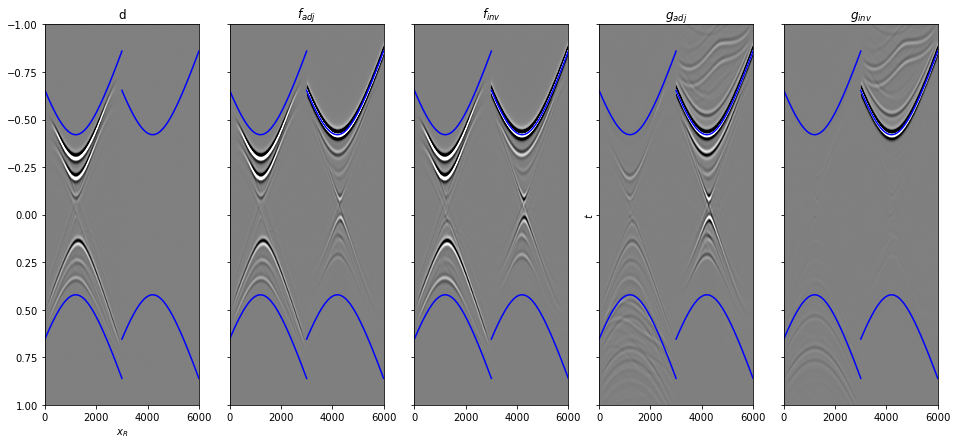

In [56]:
# Need to recreate combined data as new implementation stacks over time instead of space
d = cp.asnumpy(np.concatenate((d[:(2*nt-1)], d[(2*nt-1):]), axis=1).T)
f1_adj_tot = cp.asnumpy(np.concatenate((f1_adj_tot[:(2*nt-1)], f1_adj_tot[(2*nt-1):]), axis=1).T)
f1_inv_tot = cp.asnumpy(np.concatenate((f1_inv_tot[:(2*nt-1)], f1_inv_tot[(2*nt-1):]), axis=1).T)
g_adj = cp.asnumpy(np.concatenate((g_adj[:(2*nt-1)], g_adj[(2*nt-1):]), axis=1).T)
g_inv = cp.asnumpy(np.concatenate((g_inv[:(2*nt-1)], g_inv[(2*nt-1):]), axis=1).T)

fig, axs = plt.subplots(1, 5, sharey=True, figsize=(16, 7))
axs[0].imshow(d.T, cmap='gray', vmin=-5e5, vmax=5e5, extent=(r[0,0], 2*r[0,-1], t[-1], -t[-1]))
axs[0].set_title('d'), axs[0].set_xlabel(r'$x_R$'), axs[3].set_ylabel(r'$t$')
axs[0].plot(r[0], directVS,'b'),axs[0].plot(r[0], -directVS,'b')
axs[0].plot(r[0]+r[0,-1], directVS,'b'),axs[0].plot(r[0]+r[0,-1], -directVS,'b')
axs[0].axis('tight')
axs[0].set_ylim(1, -1)
axs[1].imshow(f1_adj_tot.T, cmap='gray', vmin=-5e5, vmax=5e5, extent=(r[0,0], 2*r[0,-1], t[-1], -t[-1]))
axs[1].set_title(r'$f_{adj}$'), axs[0].set_xlabel(r'$x_R$')
axs[1].plot(r[0], directVS,'b'),axs[1].plot(r[0], -directVS,'b')
axs[1].plot(r[0]+r[0,-1], directVS,'b'),axs[1].plot(r[0]+r[0,-1], -directVS,'b')
axs[1].axis('tight')
axs[1].set_ylim(1, -1);
axs[2].imshow(f1_inv_tot.T, cmap='gray', vmin=-5e5, vmax=5e5, extent=(r[0,0], 2*r[0,-1], t[-1], -t[-1]))
axs[2].set_title(r'$f_{inv}$'), axs[0].set_xlabel(r'$x_R$')
axs[2].plot(r[0], directVS,'b'),axs[2].plot(r[0], -directVS,'b')
axs[2].plot(r[0]+r[0,-1], directVS,'b'),axs[2].plot(r[0]+r[0,-1], -directVS,'b')
axs[2].axis('tight')
axs[2].set_ylim(1, -1);
axs[3].imshow(g_adj.T, cmap='gray', vmin=-5e5, vmax=5e5, extent=(r[0,0], 2*r[0,-1], t[-1], -t[-1]))
axs[3].set_title(r'$g_{adj}$'), axs[0].set_xlabel(r'$x_R$')
axs[3].plot(r[0], directVS,'b'),axs[3].plot(r[0], -directVS,'b')
axs[3].plot(r[0]+r[0,-1], directVS,'b'),axs[3].plot(r[0]+r[0,-1], -directVS,'b')
axs[3].axis('tight')
axs[3].set_ylim(1, -1);
axs[4].imshow(g_inv.T, cmap='gray', vmin=-5e5, vmax=5e5, extent=(r[0,0], 2*r[0,-1], t[-1], -t[-1]))
axs[4].set_title(r'$g_{inv}$'), axs[0].set_xlabel(r'$x_R$')
axs[4].plot(r[0], directVS,'b'),axs[4].plot(r[0], -directVS,'b')
axs[4].plot(r[0]+r[0,-1], directVS,'b'),axs[4].plot(r[0]+r[0,-1], -directVS,'b')
axs[4].axis('tight')
axs[4].set_ylim(1, -1);

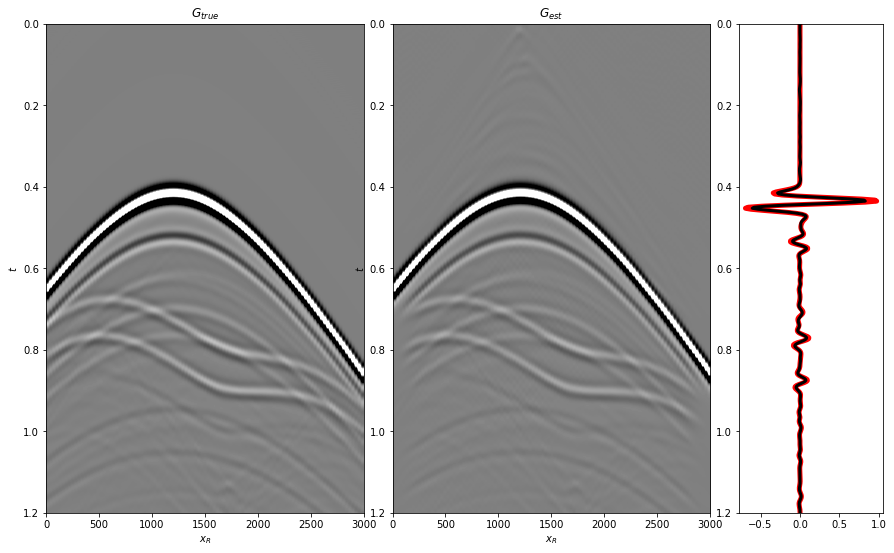

In [57]:
fig = plt.figure(figsize=(15,9))
ax1 = plt.subplot2grid((1, 5), (0, 0), colspan=2)
ax2 = plt.subplot2grid((1, 5), (0, 2), colspan=2)
ax3 = plt.subplot2grid((1, 5), (0, 4))

ax1.imshow(Gsub, cmap='gray', vmin=-5e5, vmax=5e5, extent=(r[0,0], r[0,-1], t[-1], t[0]))
ax1.set_title(r'$G_{true}$'), ax1.set_xlabel(r'$x_R$'), ax1.set_ylabel(r'$t$')
ax1.axis('tight')
ax1.set_ylim(1.2, 0)
ax2.imshow(cp.asnumpy(g_inv_tot).T, cmap='gray', vmin=-5e5, vmax=5e5, 
           extent=(r[0,0], r[0,-1], t[-1], -t[-1]))
ax2.set_title(r'$G_{est}$'), ax2.set_xlabel(r'$x_R$'), ax2.set_ylabel(r'$t$')
ax2.axis('tight')
ax2.set_ylim(1.2, 0)

ax3.plot(Gsub[:, nr//2]/Gsub.max(), t, 'r', lw=5)
ax3.plot(cp.asnumpy(g_inv_tot)[nr//2, nt-1:]/cp.asnumpy(g_inv_tot).max(), t, 'k', lw=3)
ax3.set_ylim(1.2, 0);

## Function

In [58]:
"""
MarchenkoWM = Marchenko(Rtwosided_fft.transpose(1, 2, 0), nt=nt, dt=dt, dr=dr, 
                        nfmax=nfmax, wav=wav, toff=toff, nsmooth=nsmooth) # R[r, s, f]

f1_inv_minus_f, f1_inv_plus_f, p0_minus_f, g_inv_minus_f, g_inv_plus_f = \
  MarchenkoWM.apply_onepoint(directVS, G0=G0sub.T, rtm=True, greens=True, 
                             dottest=True, **dict(niter=n_iter, show=True))
g_inv_tot_f = g_inv_minus_f + g_inv_plus_f
"""

"""
MarchenkoWM = Marchenko(R, dt=dt, dr=dr, nfmax=nfmax, wav=wav,
                        toff=toff, nsmooth=nsmooth)

f1_inv_minus_f, f1_inv_plus_f, p0_minus_f, g_inv_minus_f, g_inv_plus_f = \
    MarchenkoWM.apply_onepoint(directVS, G0=G0sub.T, rtm=True, greens=True, 
                               dottest=False, **dict(niter=n_iter, show=True))
g_inv_tot_f = g_inv_minus_f + g_inv_plus_f
"""

MarchenkoWM = Marchenko(R, dt=dt, dr=dr, nfmax=nfmax, wav=wav,
                        toff=toff, nsmooth=nsmooth)

f1_inv_minus_f, f1_inv_plus_f, p0_minus_f, g_inv_minus_f, g_inv_plus_f = \
    MarchenkoWM.apply_onepoint(directVS, nfft=2**11, rtm=True, greens=True, 
                               dottest=False, **dict(niter=n_iter, show=True))
f1_inv_minus_f, f1_inv_plus_f, p0_minus_f, g_inv_minus_f, g_inv_plus_f = \
  1e6*f1_inv_minus_f, 1e6*f1_inv_plus_f, 1e6*p0_minus_f, 1e6*g_inv_minus_f, 1e6*g_inv_plus_f 
g_inv_tot_f = g_inv_minus_f + g_inv_plus_f

/home/ravasim/Documents/OpenSource/pylops/pylops/signalprocessing/fft.py:59: UserWarning: numpy backend always returns complex128 dtype. To respect the passed dtype, data will be casted to complex64.
  warnings.warn(


CGLS
-----------------------------------------------------------------
The Operator Op has 322998 rows and 322998 cols
damp = 0.000000e+00	tol = 1.000000e-04	niter = 10
-----------------------------------------------------------------

    Itn          x[0]              r1norm         r2norm
     1        0.0000e+00         1.7338e+01     1.7338e+01
     2        0.0000e+00         9.7920e+00     9.7920e+00
     3        0.0000e+00         7.2422e+00     7.2422e+00
     4        0.0000e+00         4.8379e+00     4.8379e+00
     5        0.0000e+00         3.6741e+00     3.6741e+00
     6        0.0000e+00         2.9634e+00     2.9634e+00
     7        0.0000e+00         1.9796e+00     1.9796e+00
     8        0.0000e+00         1.4603e+00     1.4603e+00
     9        0.0000e+00         1.1865e+00     1.1865e+00
    10        0.0000e+00         8.8536e-01     8.8536e-01

Iterations = 10        Total time (s) = 0.68
-----------------------------------------------------------------



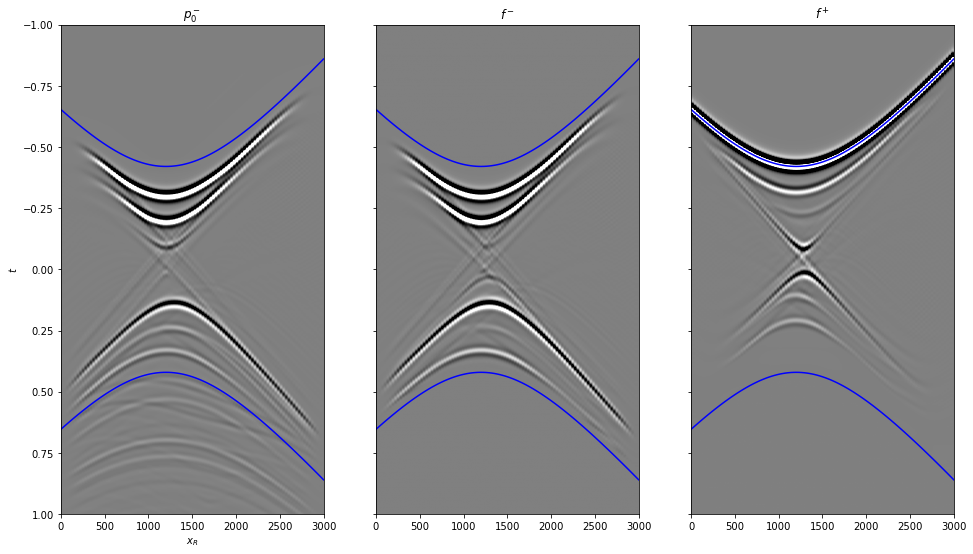

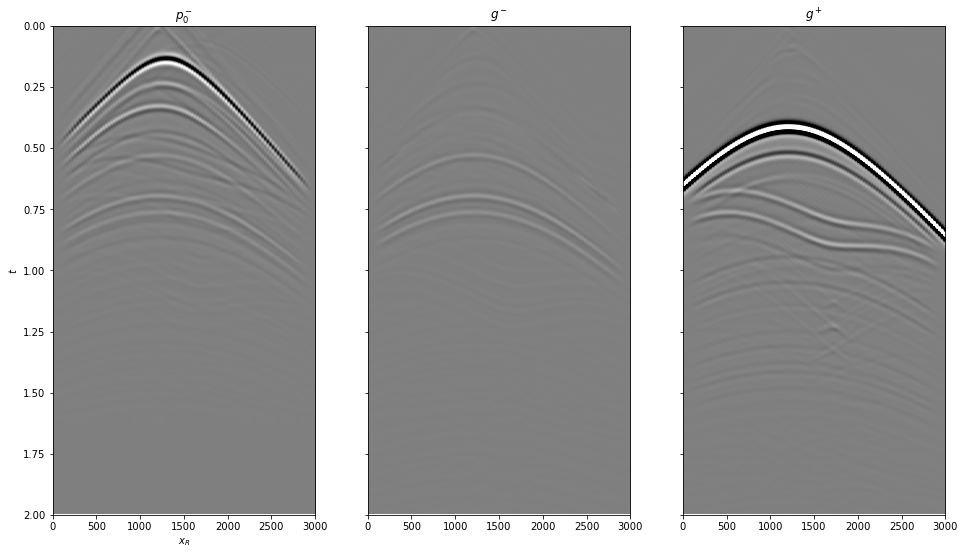

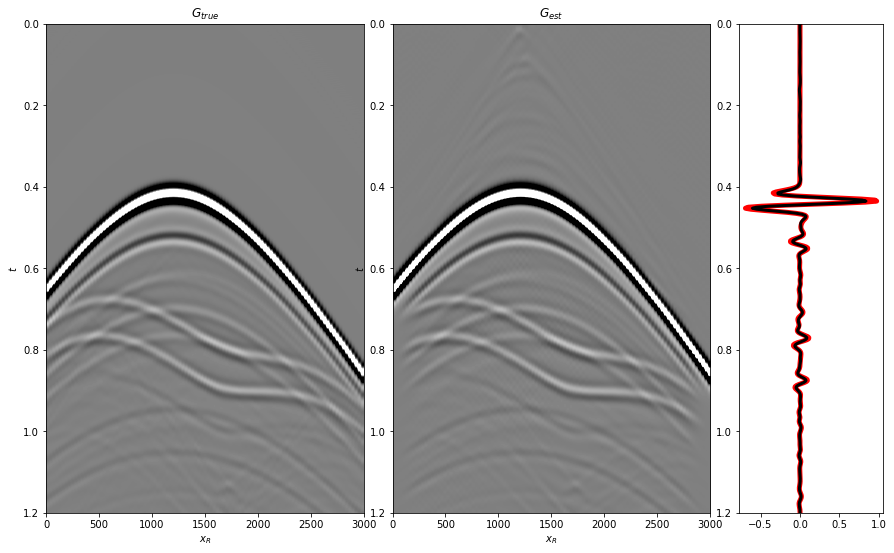

In [59]:
fig, axs = plt.subplots(1, 3, sharey=True, figsize=(16, 9))
axs[0].imshow(cp.asnumpy(p0_minus_f).T, cmap='gray', vmin=-5e5, vmax=5e5, extent=(r[0,0], r[0,-1], t[-1], -t[-1]))
axs[0].set_title(r'$p_0^-$'), axs[0].set_xlabel(r'$x_R$'), axs[0].set_ylabel(r'$t$')
axs[0].plot(r[0], directVS,'b'),axs[0].plot(r[0], -directVS,'b')
axs[0].axis('tight')
axs[0].set_ylim(1, -1);
axs[1].imshow(cp.asnumpy(f1_inv_minus_f).T, cmap='gray', vmin=-5e5, vmax=5e5, extent=(r[0,0], r[0,-1], t[-1], -t[-1]))
axs[1].set_title(r'$f^-$'), axs[0].set_xlabel(r'$x_R$')
axs[1].plot(r[0], directVS,'b'),axs[1].plot(r[0], -directVS,'b')
axs[1].axis('tight')
axs[1].set_ylim(1, -1);
axs[2].imshow(cp.asnumpy(f1_inv_plus_f).T, cmap='gray', vmin=-5e5, vmax=5e5, extent=(r[0,0], r[0,-1], t[-1], -t[-1]))
axs[2].set_title(r'$f^+$'), axs[0].set_xlabel(r'$x_R$')
axs[2].plot(r[0], directVS,'b'),axs[2].plot(r[0], -directVS,'b')
axs[2].axis('tight')
axs[2].set_ylim(1, -1);

fig, axs = plt.subplots(1, 3, sharey=True, figsize=(16, 9))
axs[0].imshow(cp.asnumpy(p0_minus_f).T, cmap='gray', vmin=-5e5, vmax=5e5, extent=(r[0,0], r[0,-1], t[-1], -t[-1]))
axs[0].set_title(r'$p_0^-$'), axs[0].set_xlabel(r'$x_R$'), axs[0].set_ylabel(r'$t$')
axs[0].axis('tight')
axs[0].set_ylim(2, 0);
axs[1].imshow(cp.asnumpy(g_inv_minus_f).T, cmap='gray', vmin=-5e5, vmax=5e5, extent=(r[0,0], r[0,-1], t[-1], -t[-1]))
axs[1].set_title(r'$g^-$'), axs[0].set_xlabel(r'$x_R$')
axs[1].axis('tight')
axs[1].set_ylim(2, 0);
axs[2].imshow(cp.asnumpy(g_inv_plus_f).T, cmap='gray', vmin=-5e5, vmax=5e5, extent=(r[0,0], r[0,-1], t[-1], -t[-1]))
axs[2].set_title(r'$g^+$'), axs[0].set_xlabel(r'$x_R$')
axs[2].axis('tight')
axs[2].set_ylim(2, 0);

fig = plt.figure(figsize=(15,9))
ax1 = plt.subplot2grid((1, 5), (0, 0), colspan=2)
ax2 = plt.subplot2grid((1, 5), (0, 2), colspan=2)
ax3 = plt.subplot2grid((1, 5), (0, 4))

ax1.imshow(Gsub, cmap='gray', vmin=-5e5, vmax=5e5, extent=(r[0,0], r[0,-1], t[-1], t[0]))
ax1.set_title(r'$G_{true}$'), ax1.set_xlabel(r'$x_R$'), ax1.set_ylabel(r'$t$')
ax1.axis('tight')
ax1.set_ylim(1.2, 0)
ax2.imshow(cp.asnumpy(g_inv_tot_f).T, cmap='gray', vmin=-5e5, vmax=5e5, 
              extent=(r[0,0], r[0,-1], t[-1], -t[-1]))
ax2.set_title(r'$G_{est}$'), ax2.set_xlabel(r'$x_R$'), ax2.set_ylabel(r'$t$')
ax2.axis('tight')
ax2.set_ylim(1.2, 0)

ax3.plot(Gsub[:, nr//2]/Gsub.max(), t, 'r', lw=5)
ax3.plot(cp.asnumpy(g_inv_tot_f)[nr//2, nt-1:]/cp.asnumpy(g_inv_tot_f).max(), t, 'k', lw=3)
ax3.set_ylim(1.2, 0);

## Multiple points

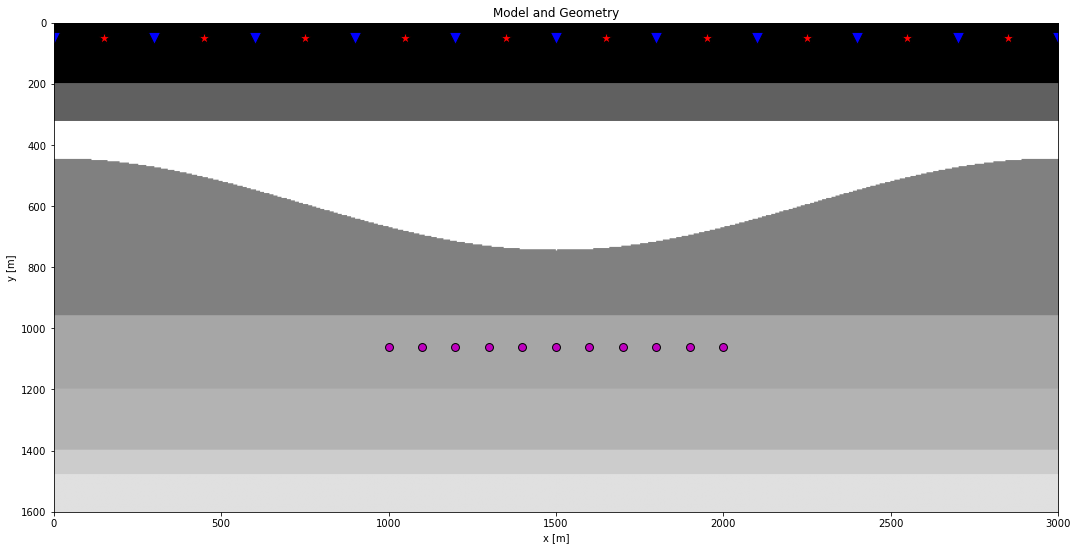

In [60]:
nvs = 11
vs = [np.arange(11)*100 + 1000, 
      np.ones(11)*1060]

plt.figure(figsize=(18,9))
plt.imshow(rho, cmap='gray', extent = (x[0], x[-1], z[-1], z[0]))
plt.scatter(s[0, 5::10], s[1, 5::10], marker='*', s=150, c='r', edgecolors='k')
plt.scatter(r[0, ::10],  r[1, ::10], marker='v', s=150, c='b', edgecolors='k')
plt.scatter(vs[0], vs[1], marker='.', s=250, c='m', edgecolors='k')
plt.axis('tight')
plt.xlabel('x [m]'),plt.ylabel('y [m]'),plt.title('Model and Geometry')
plt.xlim(x[0], x[-1]);

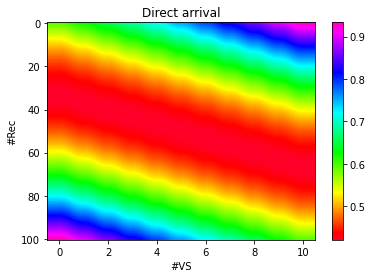

In [61]:
# direct arrival window - traveltime
directVS = np.sqrt((vs[0]-r[0][:, np.newaxis])**2+(vs[1]-r[1][:, np.newaxis])**2)/vel
directVS_off = directVS - toff

plt.figure()
im = plt.imshow(directVS, cmap='gist_rainbow')
plt.axis('tight')
plt.xlabel('#VS'),plt.ylabel('#Rec'),plt.title('Direct arrival')
plt.colorbar(im);

/tmp/ipykernel_22783/2462235176.py:1: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  idirectVS_off = np.round(directVS_off/dt).astype(np.int)


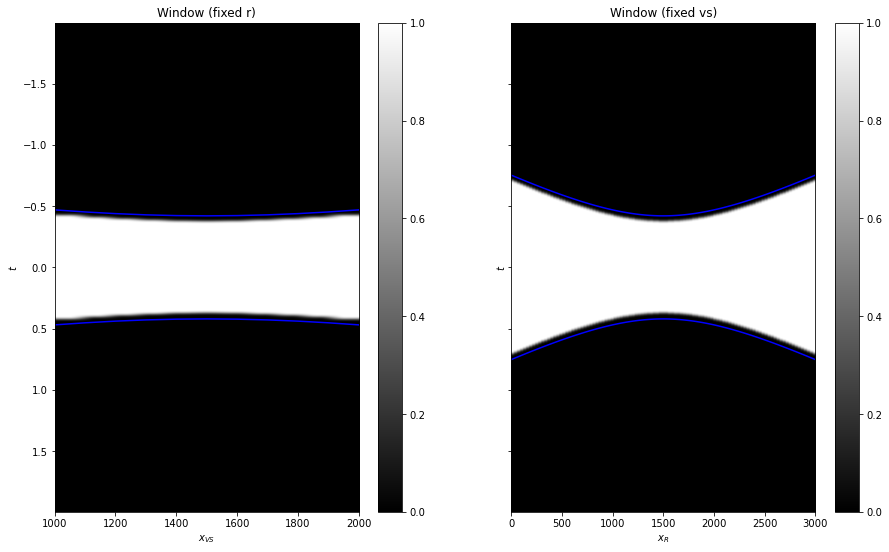

In [62]:
idirectVS_off = np.round(directVS_off/dt).astype(np.int)
w = np.zeros((nr, nvs, nt))
for ir in range(nr):
    for ivs in range(nvs):
        w[ir, ivs, :idirectVS_off[ir, ivs]]=1            
w = np.concatenate((np.flip(w, axis=-1), w[:,:, 1:]), axis=-1)

if nsmooth>0:
    smooth=np.ones(nsmooth)/nsmooth
    w  = filtfilt(smooth, 1, w)    

fig, axs = plt.subplots(1, 2,  sharey=True, figsize=(15, 9))
im = axs[0].imshow(w[nr//2].T, cmap='gray', extent=(vs[0][0], vs[0][-1], t[-1], -t[-1]))
axs[0].plot(vs[0], directVS[nr//2],'b'),axs[0].plot(vs[0], -directVS[nr//2],'b')
axs[0].set_title('Window (fixed r)'), axs[0].set_xlabel(r'$x_{VS}$'), axs[0].set_ylabel(r'$t$')
axs[0].axis('tight')
fig.colorbar(im, ax=axs[0])
im = axs[1].imshow(w[:, nvs//2].T, cmap='gray', 
                   extent=(r[0,0], r[0,-1], t[-1], -t[-1]))
axs[1].plot(r[0], directVS[:, nvs//2],'b'),axs[1].plot(r[0], -directVS[:, nvs//2],'b')
axs[1].set_title('Window (fixed vs)'), axs[1].set_xlabel(r'$x_R$'), axs[1].set_ylabel(r'$t$')
axs[1].axis('tight')
fig.colorbar(im, ax=axs[1]);

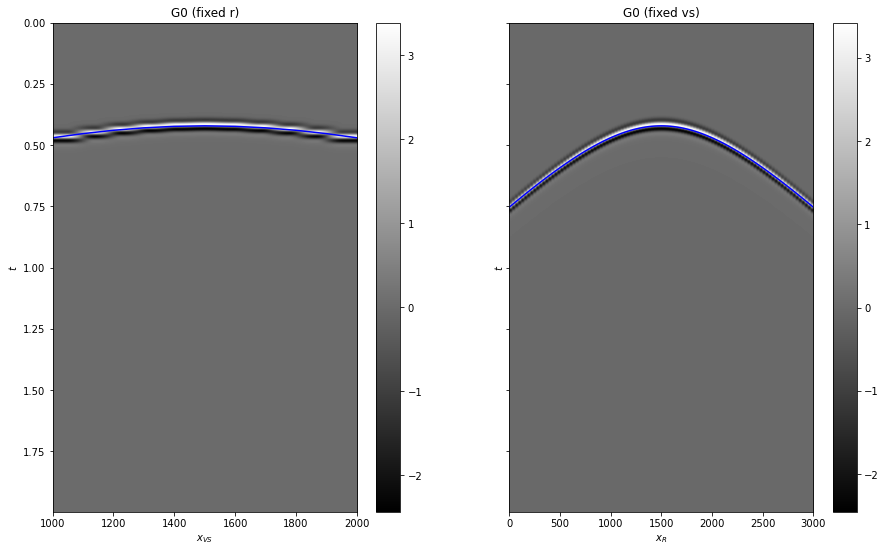

In [63]:
G0sub_ana = np.zeros((nr, nvs, nt))
for ivs in range(nvs):
    G0sub_ana[:, ivs] = directwave(wav, directVS[:,ivs], nt, dt, nfft=int(2**(np.ceil(np.log2(nt))))).T

fig, axs = plt.subplots(1, 2,  sharey=True, figsize=(15, 9))
im = axs[0].imshow(G0sub_ana[nr//2].T, cmap='gray', extent=(vs[0][0], vs[0][-1], t[-1], t[0]))
axs[0].plot(vs[0], directVS[nr//2],'b')
axs[0].set_title('G0 (fixed r)'), axs[0].set_xlabel(r'$x_{VS}$'), axs[0].set_ylabel(r'$t$')
axs[0].axis('tight')
fig.colorbar(im, ax=axs[0])
im = axs[1].imshow(G0sub_ana[:,nvs//2].T, cmap='gray', extent=(r[0,0], r[0,-1], t[-1], t[0]))
axs[1].plot(r[0], directVS[:, nvs//2],'b')
axs[1].set_title('G0 (fixed vs)'), axs[1].set_xlabel(r'$x_R$'), axs[1].set_ylabel(r'$t$')
axs[1].axis('tight')
fig.colorbar(im, ax=axs[1]);

In [64]:
MarchenkoWM = Marchenko(R, dt=dt, dr=dr, nfmax=nfmax, wav=wav,
                        toff=toff, nsmooth=nsmooth)

f1_inv_minus_f, f1_inv_plus_f, p0_minus_f, g_inv_minus_f, g_inv_plus_f = \
    MarchenkoWM.apply_multiplepoints(directVS, nfft=2**11, rtm=True, greens=True, 
                                     dottest=False, **dict(niter=n_iter, show=True))
g_inv_tot_f = g_inv_minus_f + g_inv_plus_f

/home/ravasim/Documents/OpenSource/pylops/pylops/signalprocessing/fft.py:59: UserWarning: numpy backend always returns complex128 dtype. To respect the passed dtype, data will be casted to complex64.
  warnings.warn(


CGLS
-----------------------------------------------------------------
The Operator Op has 3552978 rows and 3552978 cols
damp = 0.000000e+00	tol = 1.000000e-04	niter = 10
-----------------------------------------------------------------

    Itn          x[0]              r1norm         r2norm
     1        0.0000e+00         5.6748e+01     5.6748e+01
     2        0.0000e+00         3.1993e+01     3.1993e+01
     3        0.0000e+00         2.3761e+01     2.3761e+01
     4        0.0000e+00         1.6128e+01     1.6128e+01
     5        0.0000e+00         1.2439e+01     1.2439e+01
     6        0.0000e+00         1.0029e+01     1.0029e+01
     7        0.0000e+00         6.9378e+00     6.9378e+00
     8        0.0000e+00         5.2150e+00     5.2150e+00
     9        0.0000e+00         4.1978e+00     4.1978e+00
    10        0.0000e+00         3.1624e+00     3.1624e+00

Iterations = 10        Total time (s) = 0.60
-----------------------------------------------------------------



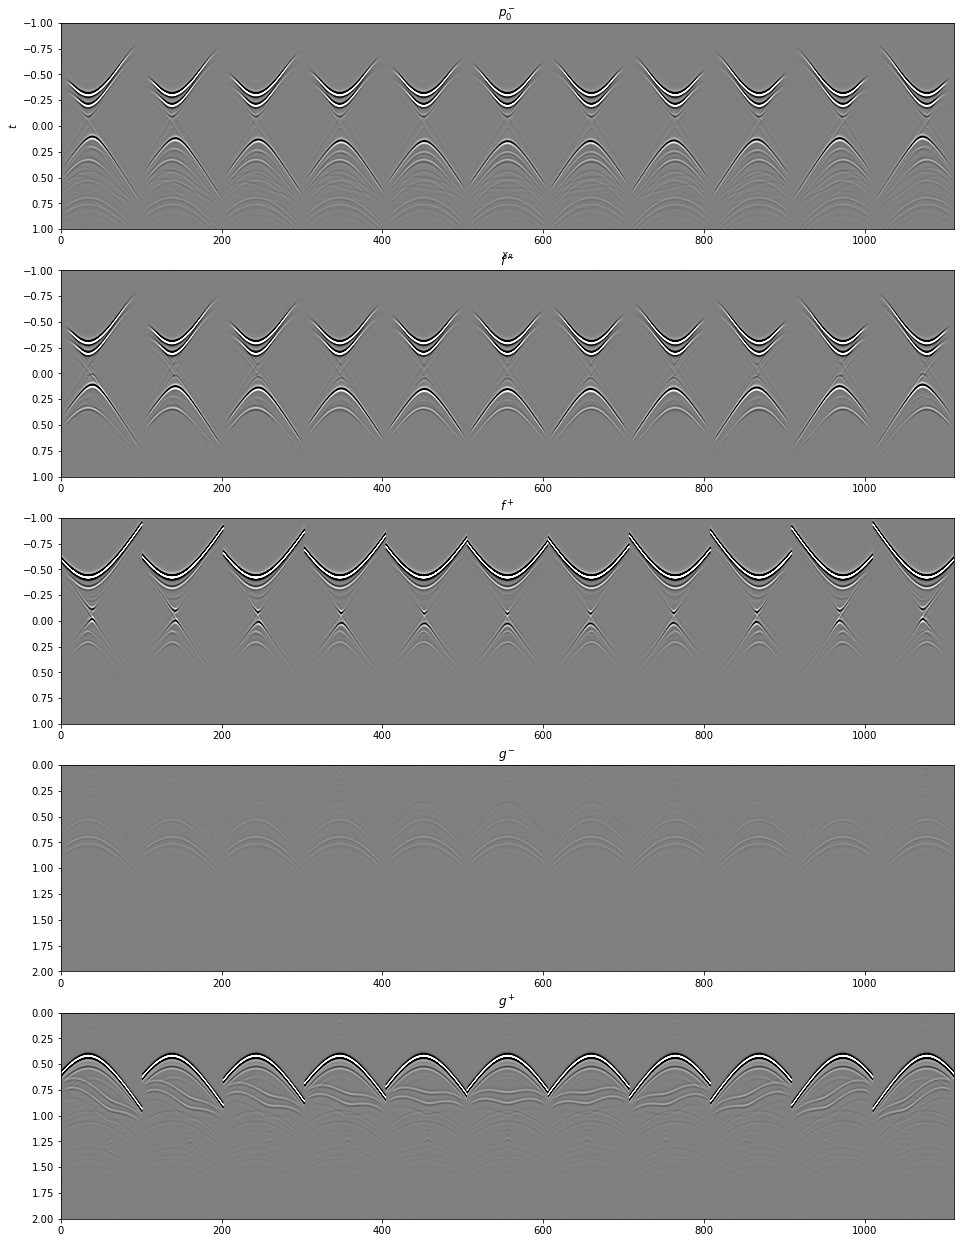

In [65]:
fig, axs = plt.subplots(5, 1, figsize=(16, 22))
axs[0].imshow(cp.asnumpy(np.swapaxes(p0_minus_f, 0, 1).reshape(nr*nvs, 2*nt-1).T), cmap='gray', 
              vmin=-5e-1, vmax=5e-1, extent=(0, nr*nvs, t[-1], -t[-1]))
axs[0].set_title(r'$p_0^-$'), axs[0].set_xlabel(r'$x_R$'), axs[0].set_ylabel(r'$t$')
axs[0].axis('tight')
axs[0].set_ylim(1, -1);
axs[1].imshow(cp.asnumpy(np.swapaxes(f1_inv_minus_f, 0, 1).reshape(nr*nvs,2*nt-1).T), cmap='gray', 
              vmin=-5e-1, vmax=5e-1, extent=(0, nr*nvs, t[-1], -t[-1]))
axs[1].set_title(r'$f^-$'), axs[0].set_xlabel(r'$x_R$')
axs[1].axis('tight')
axs[1].set_ylim(1, -1);
axs[2].imshow(cp.asnumpy(np.swapaxes(f1_inv_plus_f, 0, 1).reshape(nr*nvs,2*nt-1).T), cmap='gray', 
              vmin=-5e-1, vmax=5e-1, extent=(0, nr*nvs, t[-1], -t[-1]))
axs[2].set_title(r'$f^+$'), axs[0].set_xlabel(r'$x_R$')
axs[2].axis('tight')
axs[2].set_ylim(1, -1);
axs[3].imshow(cp.asnumpy(np.swapaxes(g_inv_minus_f, 0, 1).reshape(nr*nvs,2*nt-1).T), cmap='gray', 
              vmin=-5e-1, vmax=5e-1, extent=(0, nr*nvs, t[-1], -t[-1]))
axs[3].set_title(r'$g^-$'), axs[0].set_xlabel(r'$x_R$')
axs[3].axis('tight')
axs[3].set_ylim(2, 0);
axs[4].imshow(cp.asnumpy(np.swapaxes(g_inv_plus_f, 0, 1).reshape(nr*nvs,2*nt-1).T), cmap='gray', 
              vmin=-5e-1, vmax=5e-1, extent=(0, nr*nvs, t[-1], -t[-1]))
axs[4].set_title(r'$g^+$'), axs[0].set_xlabel(r'$x_R$')
axs[4].axis('tight')
axs[4].set_ylim(2, 0);

In [66]:
MarchenkoWMnp = Marchenko(cp.asnumpy(R), dt=dt, dr=dr, nfmax=nfmax, wav=cp.asnumpy(wav),
                          toff=toff, nsmooth=nsmooth)

%timeit -n1 -r1 MarchenkoWMnp.apply_multiplepoints(directVS, nfft=2**11, rtm=True, greens=True, dottest=False, **dict(iter_lim=n_iter, show=False));
%timeit -n1 -r1 MarchenkoWM.apply_multiplepoints(directVS, nfft=2**11, rtm=True, greens=True, dottest=False, **dict(niter=n_iter, show=False));

12.4 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
1.12 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
